In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression



## Preprocess the Data

This part we give the formula and the head 5 lines of the data

In [2]:
dat = pd.read_csv('feds.csv')
dat.Date = pd.to_datetime(dat.Date)

FileNotFoundError: File b'feds.csv' does not exist

In [5]:
dat['year'] =  pd.DatetimeIndex(dat.Date).year
dat['month'] =  pd.DatetimeIndex(dat.Date).month

In [6]:
dat_month = dat.groupby(['year','month']).first().reset_index()
year = dat_month.pop('year')
month = dat_month.pop('month')
# dat_month['year'] = year
# dat_month['month'] = month
dat_month = dat_month.set_index('Date')
dat_month = dat_month[1:]

dat_month = dat_month[dat_month.index > pd.to_datetime('1971-08-16')]
dat_month.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,
1971-08-31,5.1498,5.5307,5.7565,5.8982,5.9922,6.0578,6.1057,6.1419,6.1701,6.1928
1971-09-30,5.1603,5.5107,5.7152,5.8422,5.9257,5.9838,6.0260,6.0579,6.0828,6.1028
1971-10-29,4.5242,4.9833,5.3157,5.5276,5.6652,5.7593,5.8270,5.8779,5.9174,5.9491
1971-11-30,4.6539,5.0616,5.3648,5.5808,5.7347,5.8464,5.9295,5.9931,6.0430,6.0831
1971-12-31,4.3542,4.7912,5.1087,5.3434,5.5200,5.6554,5.7610,5.8448,5.9123,5.9677


In [15]:
bond_price = dat_month / 100

bond_price['spot'] = np.ones(len(bond_price)) 
cols = bond_price.columns.tolist()
bond_price = bond_price[[cols[-1]] + cols[:-1]] 
for i in range(11):
    bond_price.iloc[:, i] = np.exp(-bond_price.iloc[:, i] * i)
bond_price.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1971-08-31,1.0,0.949806,0.895284,0.841394,0.789838,0.741107,0.695261,0.652203,0.611799,0.573895,0.538332
1971-09-30,1.0,0.949706,0.895642,0.842437,0.791609,0.743575,0.698355,0.655852,0.615924,0.578422,0.543199
1971-10-29,1.0,0.955766,0.905140,0.852595,0.801633,0.753324,0.707825,0.665052,0.624857,0.587097,0.551612
1971-11-30,1.0,0.954527,0.903723,0.851340,0.799929,0.750711,0.704136,0.660297,0.619125,0.580497,0.544270
1971-12-31,1.0,0.957392,0.908624,0.857906,0.807562,0.758813,0.712252,0.668132,0.626514,0.587366,0.550587


In [8]:
p = np.log(bond_price)

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1971-08-31,1.0,0.949806,0.895284,0.841394,0.789838,0.741107,0.695261,0.652203,0.611799,0.573895,0.538332
1971-09-30,1.0,0.949706,0.895642,0.842437,0.791609,0.743575,0.698355,0.655852,0.615924,0.578422,0.543199
1971-10-29,1.0,0.955766,0.905140,0.852595,0.801633,0.753324,0.707825,0.665052,0.624857,0.587097,0.551612
1971-11-30,1.0,0.954527,0.903723,0.851340,0.799929,0.750711,0.704136,0.660297,0.619125,0.580497,0.544270
1971-12-31,1.0,0.957392,0.908624,0.857906,0.807562,0.758813,0.712252,0.668132,0.626514,0.587366,0.550587


$$ y_t{(n)} = -\frac1n p_t^{(n)}$$

In [17]:
y = p.copy()
for i in range(1,6):
    y.iloc[:,i] = -1.0/(i) * y.iloc[:,i]
y.spot = np.ones(len(y))

$$f_t^{(n)} = p_t^{(n-1)} - p_t^{(n)}$$

In [18]:
f = p.copy()
f = -f.diff(axis = 1)
f.spot = np.ones(len(f))

$$r_{t+1}^{(n)} = p_{t+1}^{(n-1)} - p_t^{(n)}$$

In [24]:
p1 = p.copy()
p1 = p1.shift(-12) # t+1
p1 = p1.shift(1, axis=1) # n-1
r = p1 - p
r.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1971-08-31,NaN,0.051498,0.057351,0.058221,0.057494,0.056266,0.054883,0.053461,0.052025,0.050573,0.049130
1971-09-30,NaN,0.051603,0.055776,0.055066,0.053253,0.051217,0.049168,0.047120,0.045081,0.043044,0.041021
1971-10-29,NaN,0.045242,0.045229,0.042633,0.040504,0.038668,0.036933,0.035224,0.033523,0.031814,0.030115
1971-11-30,NaN,0.046539,0.048009,0.047014,0.046475,0.046551,0.047004,0.047643,0.048367,0.049126,0.049905
1971-12-31,NaN,0.043542,0.039254,0.034853,0.032095,0.030756,0.030384,0.030604,0.031183,0.031971,0.032902


$$ rx_{t+1}^{(n)} = r_{t+1}^{(n)} - y_t^{(1)}$$

In [25]:
rx = r.copy()
for i in range(2,11):
    rx.iloc[:,i] = rx.iloc[:,i] - rx.iloc[:,1]
rx.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1971-08-31,NaN,0.051498,0.005853,0.006723,0.005996,0.004768,0.003385,0.001963,0.000527,-0.000925,-0.002368
1971-09-30,NaN,0.051603,0.004173,0.003463,0.001650,-0.000386,-0.002435,-0.004483,-0.006522,-0.008559,-0.010582
1971-10-29,NaN,0.045242,-0.000013,-0.002609,-0.004738,-0.006574,-0.008309,-0.010018,-0.011719,-0.013428,-0.015127
1971-11-30,NaN,0.046539,0.001470,0.000475,-0.000064,0.000012,0.000465,0.001104,0.001828,0.002587,0.003366
1971-12-31,NaN,0.043542,-0.004288,-0.008689,-0.011447,-0.012786,-0.013158,-0.012938,-0.012359,-0.011571,-0.010640


## Functions of Regression

In [93]:
# Function to run the regressions
def simple_model_regressions (start_train, end_train, start_test, end_test, 
                              returns_data, forwards_data, excess_ret_data, maturity):
    
    # Determine Date periods
    idx = ((returns_data.index >= pd.to_datetime(start_train)) &
           (returns_data.index <= pd.to_datetime(end_test)))
    idx_train = ((returns_data.index >= pd.to_datetime(start_train)) & 
                  (returns_data.index <= pd.to_datetime(end_train)))
    idx_test = ((returns_data.index >= pd.to_datetime(start_test)) &
                 (returns_data.index <= pd.to_datetime(end_test)))

    # Select appropiate data and divide it into train set and test set
    yt = returns_data[idx].iloc[:,1:(maturity+1)]
    ft = forwards_data[idx].iloc[:,1:(maturity+1)]
    rxt = excess_ret_data[idx].iloc[:,2:(maturity+1)]
    rxt_bar = rxt.mean(axis = 1)

    # Select 5 year train data
    yt_train = returns_data[idx_train].iloc[:,1:(maturity+1)]
    ft_train = forwards_data[idx_train].iloc[:,1:(maturity+1)]
    rxt_train = excess_ret_data[idx_train].iloc[:,2:(maturity+1)]
    rxt_bar_train = rxt_train.mean(axis = 1)

    # Select 5 year test data
    yt_test = returns_data[idx_test].iloc[:,1:(maturity+1)]
    ft_test = forwards_data[idx_test].iloc[:,1:(maturity+1)]
    rxt_test = excess_ret_data[idx_test].iloc[:,2:(maturity+1)]
    rxt_bar_test = rxt_test.mean(axis = 1)
    # First Regression
    model = LinearRegression()
    R_sq = np.zeros((maturity-1))

    model.fit(ft_train,rxt_bar_train)
    gamma = model.coef_
    R_sq = model.score(ft_train,rxt_bar_train)

    # Second Regression
    aux = pd.DataFrame(np.sum((ft_train).mul(gamma), axis = 1) + model.intercept_)

    aux_test = pd.DataFrame(np.sum((ft_test).mul(gamma), axis = 1) + model.intercept_)

    models = []
    b = np.zeros((maturity-1))
    reg_coefs = np.zeros([maturity,maturity-1])
    R_sq = np.zeros((maturity-1))
    rxt_predict = rxt_test.copy()

    for i in range((maturity-1)):
        model_b = LinearRegression()
        model_b.fit(aux,rxt_train.iloc[:,i])
        b[i] = model_b.coef_[0]
        reg_coefs[:,i] = b[i]*gamma
        rxt_predict.iloc[:,i] = model_b.predict(aux_test)
        R_sq[i] = model_b.score(aux_test,rxt_test.iloc[:,i])
        models.append(model_b)
    rxt_predict_bar = np.mean(rxt_predict, axis = 1)

    return gamma, b, reg_coefs, rxt_predict, rxt_predict_bar, rxt_bar

def simple_model_regressions_lags (start_train, end_train, start_test, end_test, 
                              returns_data, forwards_data, excess_ret_data, maturity, lags):
    
    # Determine Date periods
    idx = ((returns_data.index >= pd.to_datetime(start_train)) &
           (returns_data.index <= pd.to_datetime(end_test)))
    idx_train = ((returns_data.index >= pd.to_datetime(start_train)) & 
                  (returns_data.index <= pd.to_datetime(end_train)))
    idx_test = ((returns_data.index >= pd.to_datetime(start_test)) &
                 (returns_data.index <= pd.to_datetime(end_test)))

    # Select appropiate data and divide it into train set and test set
    yt = returns_data[idx].iloc[:,1:(maturity+1)]
    ft = forwards_data[idx].iloc[:,1:(maturity+1)]
    rxt = (excess_ret_data[idx].iloc[:,2:(maturity+1)])[lags:]
    rxt_bar = rxt.mean(axis = 1)

    # Select 5 year train data
    yt_train = returns_data[idx_train].iloc[:,1:(maturity+1)]
    ft_train = forwards_data[idx_train].iloc[:,1:(maturity+1)]
    rxt_train = (excess_ret_data[idx_train].iloc[:,2:(maturity+1)])[lags:]
    rxt_bar_train = rxt_train.mean(axis = 1)

    # Select 5 year test data
    yt_test = returns_data[idx_test].iloc[:,1:(maturity+1)]
    ft_test = forwards_data[idx_test].iloc[:,1:(maturity+1)]
    rxt_test = (excess_ret_data[idx_test].iloc[:,2:(maturity+1)])[lags:]
    rxt_bar_test = rxt_test.mean(axis = 1)
    
    a = np.zeros(lags + 1)
    for i in range (lags+1):
        a[i] = 0.3
        
    alpha_error = 1
    while (alpha_error > 0.0001):
        temp = a[0]*ft_train
        for i in range (1, lags+1):
            temp = temp + a[i]*ft_train.shift(i)
        temp = temp.dropna()

        # First Regression. Fix alpha, compute gamma coefficients
        model = LinearRegression()
        R_sq = np.zeros((maturity-1))

        model.fit(temp,rxt_bar_train)
        gamma = model.coef_
        R_sq_x = model.score(temp,rxt_bar_train)

        # Second Regression. Fix Gamma, compute alpha coefficients
        temp2 = pd.DataFrame()
        for i in range(lags + 1):
            temp2[str(i)] = np.sum(ft_train.shift(i).iloc[lags:].mul(gamma), axis = 1) + model.intercept_

        model_alpha = LinearRegression()
        model_alpha.fit(temp2, rxt_bar_train)
        alpha_coefs = model_alpha.coef_
        alpha_error = np.sum((a-alpha_coefs)**2)
        a = alpha_coefs
    
    # Third Regression. Compute b
    temp3 = a[0]*ft_train
    for i in range (1, lags+1):
        temp3 = temp3 + a[i]*ft_train.shift(i)
    temp3 = temp3.dropna()
    aux = pd.DataFrame(np.sum(temp3.mul(gamma), axis = 1) + model_alpha.intercept_)
    
    temp4 = a[0]*ft_test
    for i in range (1, lags+1):
        temp4 = temp4 + a[i]*ft_test.shift(i)
    temp4 = temp4.dropna()
    aux_test = pd.DataFrame(np.sum(temp4.mul(gamma), axis = 1) + model_alpha.intercept_)

    models = []
    b = np.zeros((maturity-1))
    reg_coefs = np.zeros([maturity,maturity-1])
    R_sq = np.zeros((maturity-1))
    rxt_predict = rxt_test.copy()
    

    for i in range((maturity-1)):
        model_b = LinearRegression()
        model_b.fit(aux,rxt_train.iloc[:,i])
        b[i] = model_b.coef_[0]
        reg_coefs[:,i] = b[i]*gamma
        rxt_predict.iloc[:,i] = model_b.predict(aux_test)
        R_sq[i] = model_b.score(aux_test,rxt_test.iloc[:,i])
        models.append(model_b)
    rxt_predict_bar = np.mean(rxt_predict, axis = 1)

    return gamma, b, reg_coefs, rxt_predict, rxt_predict_bar, rxt_bar, R_sq_x

## Prediction of Excess Return

### 10 years rolling, zero lag

In [137]:
count = 0
for i, j, w in zip(rx['1972-12-1' : '2007-8-1'].index, rx['1982-12-1' : '2017-8-1'].index,
                  rx['1983-1-1' : '2017-9-1'].index):
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll = (
        simple_model_regressions(i, j, w, w, y, f, rx, 10))
    if (count == 0):
        temp = pre_roll
    else:
        temp = temp.append(pre_roll)
    count = count + 1
rx_predict_rolling_0 = temp.SVENY10

### 10 years rolling, 3 lag

In [138]:
count = 0
for i, j, z, w in zip(rx['1972-12-1' : '2007-9-1'].index, rx['1982-12-1' : '2017-9-1'].index,
                     rx['1982-10-1' : '2017-9-1'].index, rx['1983-1-1' : '2017-9-1'].index):
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll, R_sq= (
    simple_model_regressions_lags(i, j, z, w, y, f, rx, 10, 3))
    if (count == 0):
        temp = pre_roll
    else:
        temp = temp.append(pre_roll)
    count = count + 1
rx_predict_rolling_3 = temp.SVENY10

### Extended, zero lag

In [139]:
count = 0
for j, w in zip(rx['1982-12-1' : '2017-8-1'].index,
                  rx['1983-1-1' : '2017-9-1'].index):
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll = (
        simple_model_regressions('1971-8-1', j, w, w, y, f, rx, 10))
    if (count == 0):
        temp = pre_roll
    else:
        temp = temp.append(pre_roll)
    count = count + 1
rx_predict_extended_0 = temp.SVENY10

### Extended, 3 lag

In [140]:
count = 0
for j, z, w in zip(rx['1982-12-1' : '2017-9-1'].index,
                     rx['1982-10-1' : '2017-9-1'].index, rx['1983-1-1' : '2017-9-1'].index):
    g_roll, b_x_roll, reg_co_roll, pre_roll, pre_bar_roll, rxt_average_roll, R_sq= (
    simple_model_regressions_lags('1971-8-1', j, z, w, y, f, rx, 10, 3))
    if (count == 0):
        temp = pre_roll
    else:
        temp = temp.append(pre_roll)
    count = count + 1
rx_predict_extended_3 = temp.SVENY10

In [155]:
rx_predict = pd.concat([rx_predict_rolling_0, rx_predict_rolling_3, rx_predict_extended_0, rx_predict_extended_3], axis = 1)
rx_predict.columns = ['rolling_0', 'rolling_3', 'extended_0', 'extended_3']

In [157]:
rx_predict_rolling_0[0]
rx_predict.head()

-0.05745273415010521

,rolling_0,rolling_3,extended_0,extended_3
Date,,,,
1983-01-31,-0.057453,-0.205627,-0.047698,-0.197224
1983-02-28,-0.104196,-0.285694,-0.104236,-0.284347
1983-03-31,-0.070494,-0.315879,-0.063274,-0.302861
1983-04-29,-0.039350,-0.205186,-0.031306,-0.199448
1983-05-31,-0.074532,-0.183665,-0.070508,-0.179984


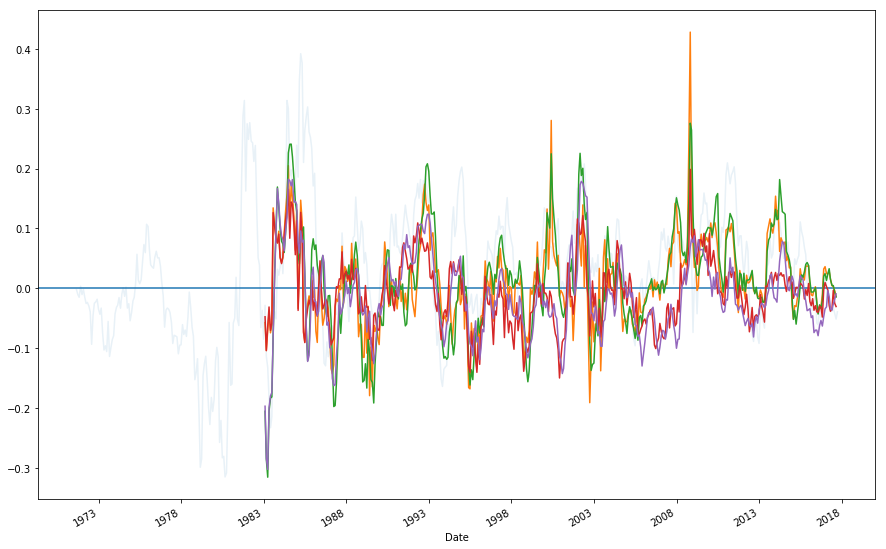

In [790]:
plt.figure(figsize=(15, 10))

plt.axhline(0)
rx.iloc[:, -1].plot(alpha = 0.1)
rx_predict.iloc[:, 0].plot()
rx_predict.iloc[:, 1].plot()
rx_predict.iloc[:, 2].plot()
rx_predict.iloc[:, 3].plot();

In [167]:
bond_price.head()
bond_price_int.head()
rx_predict.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1971-08-31,1.0,0.949806,0.895284,0.841394,0.789838,0.741107,0.695261,0.652203,0.611799,0.573895,0.538332
1971-09-30,1.0,0.949706,0.895642,0.842437,0.791609,0.743575,0.698355,0.655852,0.615924,0.578422,0.543199
1971-10-29,1.0,0.955766,0.905140,0.852595,0.801633,0.753324,0.707825,0.665052,0.624857,0.587097,0.551612
1971-11-30,1.0,0.954527,0.903723,0.851340,0.799929,0.750711,0.704136,0.660297,0.619125,0.580497,0.544270
1971-12-31,1.0,0.957392,0.908624,0.857906,0.807562,0.758813,0.712252,0.668132,0.626514,0.587366,0.550587


,0,1
Date,,
1971-08-31,0.953890,0.541209
1971-09-30,0.953799,0.546050
1971-10-29,0.959376,0.554485
1971-11-30,0.958236,0.547200
1971-12-31,0.960873,0.553562


,rolling_0,rolling_3,extended_0,extended_3
Date,,,,
1983-01-31,-0.057453,-0.205627,-0.047698,-0.197224
1983-02-28,-0.104196,-0.285694,-0.104236,-0.284347
1983-03-31,-0.070494,-0.315879,-0.063274,-0.302861
1983-04-29,-0.039350,-0.205186,-0.031306,-0.199448
1983-05-31,-0.074532,-0.183665,-0.070508,-0.179984


In [169]:
rx_predict.tail(1)

,rolling_0,rolling_3,extended_0,extended_3
Date,,,,
2017-08-31,-0.013747,-0.014562,-0.030619,-0.00945


In [186]:
def interpolate(x):
    x_3_4 = 3.0 / 4 * x[1]
    x_11_12 = 11.0 / 12 * x[1]
    x_9_3_4 = x[9] + 3.0 / 4 * (x[10] - x[9])
    x_9_11_12 = x[9] + 11.0 / 12 * (x[10] - x[9])
    return pd.Series([x_11_12, x_9_11_12])

bond_price_1_10 = bond_price.iloc[:, [1,10]]
bond_price_1_10_month = np.exp(p.apply(interpolate, axis = 1))

## Monthly Adjust

In [700]:
start_date = '1983-1-1'
end_date = '2017-1-1'

idx_range = rx_predict[start_date:end_date].index

In [701]:
bond_price_input = pd.DataFrame(index=idx_range)
bond_price_input['bond_price_1y'] = bond_price_1_10[bond_price_1_10.index.isin(idx_range)].iloc[:, 0]
bond_price_input['bond_price_10y'] = bond_price_1_10[bond_price_1_10.index.isin(idx_range)].iloc[:, 1]
bond_price_input['bond_price_1y_1month'] = bond_price_1_10_month[bond_price_1_10_month.index.isin(idx_range)].iloc[:, 0]
bond_price_input['bond_price_10y_1month'] = bond_price_1_10_month[bond_price_1_10_month.index.isin(idx_range)].iloc[:, 1]

bond_price_input.head()

,bond_price_1y,bond_price_10y,bond_price_1y_1month,bond_price_10y_1month
Date,,,,
1983-01-31,0.914727,0.335716,0.921546,0.338876
1983-02-28,0.917341,0.355056,0.923960,0.358234
1983-03-31,0.911887,0.345975,0.918923,0.349119
1983-04-29,0.916411,0.356729,0.923102,0.359873
1983-05-31,0.911757,0.340476,0.918803,0.343601


In [703]:
position = pd.DataFrame(index=idx_range)
position['value'] = 1.0
position['shares_1y'] = 0.0
position['shares_10y'] = 0.0
position.tail(1)

,value,shares_1y,shares_10y
Date,,,
2016-12-30,1.0,0.0,0.0


In [704]:
from scipy.stats import percentileofscore

In [813]:
def invest_strategy(method = 0, col_rx_predict = 0):
    _position = position.copy(deep=True)
    for i in range(len(idx_range)):
        idx = idx_range[i]
        
        excess_return = rx_predict[rx_predict.index == idx].values[0,col_rx_predict]
        if(col_rx_predict == 0 or col_rx_predict == 1):
            excess_return_past = rx[rx.index < idx].iloc[-120:-12, 10]
        else:
            excess_return_past = rx[rx.index < idx].iloc[:-12, 10]
        score = percentileofscore(excess_return_past, excess_return) / 100.0
        
        if(method == 0):
            _position.iloc[i, 1] = 1
        elif(method == 10):
            _position.iloc[i, 2] = 1
        
        
        elif(method == 1):
            if(excess_return < 0):
                _position.iloc[i, 1] = 1
            else:
                _position.iloc[i, 2] = 1
                
        elif(method == 2):               
            _position.iloc[i, 1] = 1 - score
            _position.iloc[i, 2] = score
            
            
        elif(method == 3):
            mu = excess_return_past.mean()
            sigma = excess_return_past.std()
            if(excess_return < mu- 1 * sigma):
                _position.iloc[i, 1] = 1
            elif(excess_return > mu+1 * sigma):
                _position.iloc[i, 2] = 1
            else:
                _position.iloc[i, 1] = 0.5
                _position.iloc[i, 2] = 0.5
        
        
        elif(method == 4):
            if(score < 0.25):
                _position.iloc[i, 1] = 2
                _position.iloc[i, 2] = -1
            elif(score > 0.75):
                _position.iloc[i, 1] = -1
                _position.iloc[i, 2] = 2
            else:
                if(excess_return < 0):
                    _position.iloc[i, 1] = 1
                else:
                    _position.iloc[i, 2] = 1

        if(i > 0):
            _position.iloc[i, 0] = _position.iloc[i-1, 0] * \
                (_position.iloc[i-1, 1] / bond_price_input.iloc[i-1, 0] * bond_price_input.iloc[i, 2] +
                 _position.iloc[i-1, 2] / bond_price_input.iloc[i-1, 1] * bond_price_input.iloc[i, 3]) 

    return _position

In [862]:
position_01 = invest_strategy(0)
position_10 = invest_strategy(10)
position_1 = invest_strategy(1, 3)
position_2 = invest_strategy(2, 3)
position_3 = invest_strategy(3, 3)
position_4 = invest_strategy(4, 3)

In [863]:
rf = 0.04559259
rf_month = rf / 12
(position_1.value[-1]**(1/34.0) - 1 - rf) / ((np.log(position_1.value).diff()).std() * np.sqrt(12))
(position_2.value[-1]**(1/34.0) - 1 - rf) / ((np.log(position_2.value).diff()).std() * np.sqrt(12))
(position_3.value[-1]**(1/34.0) - 1 - rf) / ((np.log(position_3.value).diff()).std() * np.sqrt(12))
(position_4.value[-1]**(1/34.0) - 1 - rf) / ((np.log(position_4.value).diff()).std() * np.sqrt(12))

0.5880733011113014

0.6069217661831469

0.5351831092128368

0.5740107803522756

In [826]:
ret = np.array([position_01.value[-1], position_10.value[-1],position_1.value[-1],
       position_2.value[-1],position_3.value[-1],position_4.value[-1]])
np.round(ret,2)
np.round(ret**(1/34.0) - 1, 4)

array([ 4.55, 23.08, 17.62, 15.33, 12.85, 34.08])

array([0.0456, 0.0967, 0.088 , 0.0836, 0.078 , 0.1094])

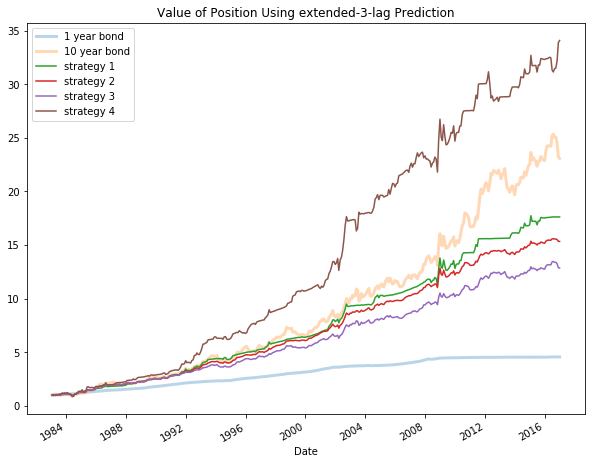

In [827]:
plt.figure(figsize = (10 , 8))
position_01.value.plot(label='1 year bond', lw = 3, alpha = 0.3)
position_10.value.plot(label='10 year bond', lw = 3, alpha = 0.3)
position_1.value.plot(label = 'strategy 1')
position_2.value.plot(label = 'strategy 2')
position_3.value.plot(label = 'strategy 3')
position_4.value.plot(label = 'strategy 4')
#plt.title('Value of Position Using 10-rolling-year-3-lag Prediction')
plt.title('Value of Position Using extended-3-lag Prediction')
plt.legend();

## Anually Adjust

In [874]:
start_date = '1983-5-1'
end_date = '2017-9-1'
idx_range = rx_predict[start_date:end_date:12].index

In [875]:
bond_price_input = pd.DataFrame(index=idx_range)
bond_price_input['bond_price_1y'] = bond_price[bond_price.index.isin(idx_range)].iloc[:, 1]
bond_price_input['bond_price_10y'] = bond_price[bond_price.index.isin(idx_range)].iloc[:, 10]
bond_price_input['bond_price_0y'] = 1
bond_price_input['bond_price_9y'] = bond_price[bond_price.index.isin(idx_range)].iloc[:, 9]

In [876]:
position = pd.DataFrame(index=idx_range)
position['value'] = 1.0
position['shares_1y'] = 0.0
position['shares_10y'] = 0.0

In [877]:
position_01 = invest_strategy(0)
position_10 = invest_strategy(10)
position_1 = invest_strategy(1, 0)
position_2 = invest_strategy(2, 0)
position_3 = invest_strategy(3, 0)
position_4 = invest_strategy(4, 0)

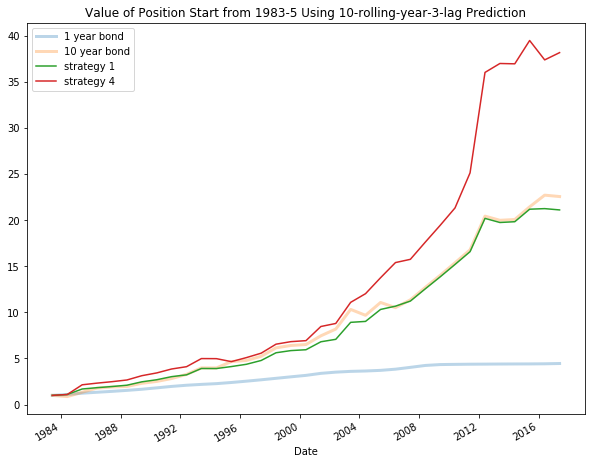

In [879]:
plt.figure(figsize = (10 , 8))
position_01.value.plot(label='1 year bond', lw = 3, alpha = 0.3)
position_10.value.plot(label='10 year bond', lw = 3, alpha = 0.3)
position_1.value.plot(label = 'strategy 1')
position_4.value.plot(label = 'strategy 4')
plt.legend()
plt.title('Value of Position Start from 1983-5 Using 10-rolling-year-3-lag Prediction');